<a href="https://colab.research.google.com/github/gylam/siads696-sprsum2024-team05/blob/main/5_failure_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Failure analysis
This notebook looks at some of the misclassified documents from the best classification model (logistic regression). Commentary on misclassified documents can be found in the Failure Analysis section of the report.

Note that some of the code is replicated from the supervised learning notebook to use some of the intermediate objects before that notebook was finalized. Also, the exact balanced dataset used in the supervised learning notebook could not be obtained for this script due to not setting a random state in its creation. However, the trends in misclassified documents should still be similar.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/_Course materials/S5M1-2 696 - Milestone II/Milestone 2 shared folder/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Dataset preprocessing
Filter to top 10 themes, generate balanced dataset

In [3]:
# Read in all single-theme documents with preprocessed text
df_cleaned = pd.read_pickle(base_path + 'data/m2_dataset_clean.pkl')
print(f'Original dataframe shape: {df_cleaned.shape}')

Original dataframe shape: (181469, 18)


In [4]:
# Filter dataset to top 10 themes
df1 = df_cleaned[['combined_text', 'cleaned_text', 'theme_name', 'report_id']].copy()

top_10_themes = list(df1['theme_name'].value_counts()[:10].reset_index()['theme_name'])

df1 = df1[df1['theme_name'].isin(top_10_themes)]
print(f'df1 shape after filtering for top 10 themes: {df1.shape}')
df1['theme_name'].value_counts()

df1 shape after filtering for top 10 themes: (161874, 4)


theme_name
Protection and Human Rights       62596
Health                            36493
Peacekeeping and Peacebuilding    11404
Recovery and Reconstruction        9524
Food and Nutrition                 8766
Shelter and Non-Food Items         8387
Contributions                      7628
Agriculture                        6581
Water Sanitation Hygiene           5306
Disaster Management                5189
Name: count, dtype: int64

In [5]:
# Generate balanced dataset

def balance_dataset(df, documents_per_label):
  df_balanced = pd.DataFrame(columns = list(df.columns))

  for theme in top_10_themes:
    try:
      df_theme = df[df['theme_name'] == theme].sample(documents_per_label, random_state = 0)
    except:
      df_theme = df[df['theme_name'] == theme]
    df_balanced = pd.concat([df_balanced, df_theme])
  return df_balanced

df2 = balance_dataset(df1, 2000).sort_values(by = ['theme_name', 'report_id'])

# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['theme_name'].factorize()[0]
category_id_df = df2[['theme_name', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'theme_name']].values)

print(f'Shape of balanced dataset (df2): {df2.shape}')
df2.head()

Shape of balanced dataset (df2): (20000, 5)


,combined_text,cleaned_text,theme_name,report_id,category_id
138,UN Food Agencies alarmed at catastrophic impac...,food agencies alarm catastrophic impact drough...,Agriculture,32508,0
514,Sierra Leone: FAO Agricultural Relief Componen...,launch day launch effort focus attention world...,Agriculture,57589,0
24,Oxfam U.K. Cambodia/Vietnam floods report The ...,flood report water level river flow high cause...,Agriculture,69685,0
803,Distribution of essential inputs in central Af...,essential input central approve project essent...,Agriculture,83913,0
60,FAO TCOR's Focus on Afghanistan Special Relief...,estimate assist farm family continue produce f...,Agriculture,90018,0


# Vectorizer
Use TfidfVectorizer on 'combined_text' column

In [6]:
text_column = 'combined_text'

# Use finalized parameters for vectorizer - from supervised learning notebook
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english', max_features=5000)

# We transform each document into a vector
features = tfidf.fit_transform(df2[text_column]).toarray()
labels = df2.category_id
print("Each of the %d report is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 20000 report is represented by 5000 features (TF-IDF score of unigrams and bigrams)


# Train/test split, model generation

In [7]:
# train test split

train_df, test_df = train_test_split(df2, test_size = 0.2, random_state = 1)
xtrain_tfidf = tfidf.transform(train_df[text_column])
xtest_tfidf = tfidf.transform(test_df[text_column])

print(f'train_df.shape: {train_df.shape}, test_df.shape: {test_df.shape}')
print(f'xtrain_tfidf.shape: {xtrain_tfidf.shape}, xtest_tfidf.shape: {xtest_tfidf.shape}')

display(train_df.head())
display(test_df.head())

train_df.shape: (16000, 5), test_df.shape: (4000, 5)
xtrain_tfidf.shape: (16000, 5000), xtest_tfidf.shape: (4000, 5000)


,combined_text,cleaned_text,theme_name,report_id,category_id
287,"""Without good nutrition, you can never have he...",good nutrition healthy child healthy community...,Food and Nutrition,566100,3
666,Cambodia COVID-19 Lockdown: Food Security and ...,implement overnight curfew lockdown measure vi...,Food and Nutrition,3739121,3
575,Flood Management in Dakar: The World Bank Step...,approve financing country reduce anticipate fl...,Disaster Management,3975864,2
729,WFP Signs Agreements With The Government Of Ye...,sign agreement today provide food nutritional ...,Food and Nutrition,567781,3
1145,PRCS Provides Relief Aid in Ein Al Rishras *(A...,team provide relief aid family affect demoliti...,Shelter and Non-Food Items,1398706,8


,combined_text,cleaned_text,theme_name,report_id,category_id
732,Q&A: Why new peace talks on CAR really matter ...,peace talk matter round peace talk arm group g...,Peacekeeping and Peacebuilding,2961539,5
1225,Central gov't sends relief goods to flood-hit ...,central sends relief good civil affair ministr...,Shelter and Non-Food Items,450443,8
666,"Finland grants EUR 300,000 for earthquake assi...",finland grant earthquake assistance release de...,Contributions,327889,1
863,Korean troops help provide clean water for Hai...,korean troop provide clean water resident four...,Water Sanitation Hygiene,449428,9
145,How Dry Is the Thai Drought This Year? By Asar...,past wet season boat restaurant fill tourist p...,Agriculture,3226008,0


In [8]:
# Model training and prediction - using parameters for best model from supervised learning notebook
model = LogisticRegression(C=10, dual=True, fit_intercept=False, solver='liblinear', max_iter = 100, random_state=0)
model.fit(xtrain_tfidf, train_df['theme_name'])
y_pred = model.predict(xtest_tfidf)

In [9]:
# Print top features per theme
idx=0
for theme in list(model.classes_):
    print(theme)
    curr_df = pd.DataFrame({"coef": model.coef_[idx], "coef_abs": np.abs(model.coef_[idx]), "word": tfidf.get_feature_names_out()})
    display(curr_df.sort_values("coef_abs", ascending = False).head(10))
    idx+=1

Agriculture


,coef,coef_abs,word
367,12.231688,12.231688,agricultural
370,11.786127,11.786127,agriculture
1761,10.355539,10.355539,farmers
2118,9.018534,9.018534,hectares
2674,8.150032,8.150032,livestock
423,7.636027,7.636027,animals
1131,7.310545,7.310545,crops
1762,7.142676,7.142676,farming
1755,6.118503,6.118503,fao
4065,6.008033,6.008033,seed


Contributions


,coef,coef_abs,word
66,10.953646,10.953646,2001
2883,10.111411,10.111411,million
65,9.728341,9.728341,2000
1054,9.387391,9.387391,contribution
57,7.683968,7.683968,1999
77,-7.487743,7.487743,2012
25,7.138701,7.138701,100 000
1771,6.963797,6.963797,fax
2018,6.961768,6.961768,grant
67,6.367198,6.367198,2002


Disaster Management


,coef,coef_abs,word
3459,8.887578,8.887578,preparedness
1358,8.418218,8.418218,disasters
1348,7.022436,7.022436,disaster
1761,-6.972288,6.972288,farmers
3928,6.470279,6.470279,risk
3855,6.422985,6.422985,resilience
3305,-6.245661,6.245661,peace
3698,-6.224757,6.224757,reconstruction
3705,-6.116599,6.116599,recovery
4773,-6.039134,6.039134,victims


Food and Nutrition


,coef,coef_abs,word
1858,25.280350,25.280350,food
3115,10.188926,10.188926,nutrition
4904,9.498966,9.498966,wfp
2764,9.426670,9.426670,malnutrition
1054,-8.240169,8.240169,contribution
3911,7.833179,7.833179,rice
2809,7.686042,7.686042,meals
620,-7.659336,7.659336,blankets
1761,-7.124580,7.124580,farmers
4852,-7.065961,7.065961,water


Health


,coef,coef_abs,word
2095,15.997231,15.997231,health
2825,11.370802,11.370802,medical
739,9.550984,9.550984,cases
4852,-8.326277,8.326277,water
3397,7.243573,7.243573,polio
1858,-6.849983,6.849983,food
2755,6.554054,6.554054,malaria
2906,6.151128,6.151128,ministry health
2171,6.121778,6.121778,hospitals
730,6.110462,6.110462,care


Peacekeeping and Peacebuilding


,coef,coef_abs,word
3305,12.070555,12.070555,peace
758,8.009224,8.009224,ceasefire
4852,-7.113887,7.113887,water
2883,-6.752514,6.752514,million
3313,6.443360,6.443360,peacebuilding
69,-6.369375,6.369375,2004
1858,-5.913903,5.913903,food
1348,-5.889850,5.889850,disaster
2203,-5.267037,5.267037,humanitarian
817,-5.207081,5.207081,children


Protection and Human Rights


,coef,coef_abs,word
4852,-9.360736,9.360736,water
3564,8.267445,8.267445,protection
3917,6.606279,6.606279,rights
3561,6.147052,6.147052,protect
69,6.000647,6.000647,2004
3305,-5.945051,5.945051,peace
1858,-5.917938,5.917938,food
2883,-5.895280,5.895280,million
3393,5.863205,5.863205,police
4904,-5.809672,5.809672,wfp


Recovery and Reconstruction


,coef,coef_abs,word
3705,12.251637,12.251637,recovery
3698,9.922081,9.922081,reconstruction
1761,-7.865062,7.865062,farmers
4852,-7.682822,7.682822,water
4904,-7.025711,7.025711,wfp
3680,6.929141,6.929141,rebuilding
2492,6.673340,6.673340,jobs
3757,6.355289,6.355289,rehabilitation
3679,6.076111,6.076111,rebuild
4133,-5.954416,5.954416,shelter


Shelter and Non-Food Items


,coef,coef_abs,word
4133,15.181351,15.181351,shelter
620,12.476732,12.476732,blankets
1858,-12.014505,12.014505,food
4135,10.874269,10.874269,shelters
3063,8.133524,8.133524,nfi
4499,7.850094,7.850094,tents
4841,-7.430692,7.430692,wash
2883,-7.249004,7.249004,million
4852,-6.904473,6.904473,water
3911,-6.704528,6.704528,rice


Water Sanitation Hygiene


,coef,coef_abs,word
4852,23.945497,23.945497,water
4841,12.209594,12.209594,wash
4005,9.301473,9.301473,sanitation
2226,8.733979,8.733979,hygiene
1858,-8.501683,8.501683,food
1436,6.883074,6.883074,drinking
4117,5.949765,5.949765,sewage
859,5.917542,5.917542,clean water
1835,-5.732196,5.732196,flood
857,5.702826,5.702826,clean


# Combine predicted labels and probabilities with original data

In [10]:
# Add predicted labels and probabilities to test_df
test_df_labels = test_df.copy()
test_df_labels['predicted_theme'] = y_pred
test_df_labels['prob'] = model.predict_proba(xtest_tfidf).max(axis = 1)
test_df_labels.head()

,combined_text,cleaned_text,theme_name,report_id,category_id,predicted_theme,prob
732,Q&A: Why new peace talks on CAR really matter ...,peace talk matter round peace talk arm group g...,Peacekeeping and Peacebuilding,2961539,5,Peacekeeping and Peacebuilding,0.596463
1225,Central gov't sends relief goods to flood-hit ...,central sends relief good civil affair ministr...,Shelter and Non-Food Items,450443,8,Agriculture,0.585131
666,"Finland grants EUR 300,000 for earthquake assi...",finland grant earthquake assistance release de...,Contributions,327889,1,Contributions,0.931762
863,Korean troops help provide clean water for Hai...,korean troop provide clean water resident four...,Water Sanitation Hygiene,449428,9,Water Sanitation Hygiene,0.905521
145,How Dry Is the Thai Drought This Year? By Asar...,past wet season boat restaurant fill tourist p...,Agriculture,3226008,0,Agriculture,0.739243


In [11]:
# Merge metadata to test documents
df_test_meta = pd.merge(df_cleaned, test_df_labels, how = 'right', on = ['report_id', 'combined_text', 'cleaned_text', 'theme_name'])
print(df_test_meta.shape)
df_test_meta.head()

(4000, 21)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,date_created,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob
0,2961539,[4599],Peacekeeping and Peacebuilding,Q&A: Why new peace talks on CAR really matter,"YAOUNDÉ/Cameroon, 22 January 2019 **As a new ...",Q&A: Why new peace talks on CAR really matter ...,https://reliefweb.int/node/2961539,6.57,20.48,caf,...,2019-01-23T10:31:25+00:00,1414,The New Humanitarian,News and Press Release,117.0,911,peace talk matter round peace talk arm group g...,5,Peacekeeping and Peacebuilding,0.596463
1,450443,[4603],Shelter and Non-Food Items,Central gov't sends relief goods to flood-hit ...,China's civil affairs ministry on Monday distr...,Central gov't sends relief goods to flood-hit ...,https://reliefweb.int/node/450443,35.49,101.90,chn,...,2011-10-03T00:00:00+00:00,1424,Xinhua,News and Press Release,187.0,1117,central sends relief good civil affair ministr...,8,Agriculture,0.585131
2,327889,[4589],Contributions,"Finland grants EUR 300,000 for earthquake assi...",Press release 258/2009 Minister for Foreign Tr...,"Finland grants EUR 300,000 for earthquake assi...",https://reliefweb.int/node/327889,-2.28,117.37,idn,...,2009-10-07T04:00:00+00:00,750,Government of Finland,News and Press Release,209.0,1316,finland grant earthquake assistance release de...,1,Contributions,0.931762
3,449428,[4604],Water Sanitation Hygiene,Korean troops help provide clean water for Hai...,Korea’s fourth peacekeeping contingent is winn...,Korean troops help provide clean water for Hai...,https://reliefweb.int/node/449428,19.18,-72.43,hti,...,2011-09-28T12:41:34+00:00,1178,Korean Information Service,News and Press Release,268.0,1629,korean troop provide clean water resident four...,9,Water Sanitation Hygiene,0.905521
4,3226008,[4587],Agriculture,How Dry Is the Thai Drought This Year?,"By Asaree Thaitrakulpanich, Staff Reporter - J...",How Dry Is the Thai Drought This Year? By Asar...,https://reliefweb.int/node/3226008,15.13,101.02,tha,...,2019-07-23T02:48:24+00:00,44214,Khaosod English,News and Press Release,147.0,908,past wet season boat restaurant fill tourist p...,0,Agriculture,0.739243


# Misclassification analysis
* Determine which themes are most likely to be misclassified
* Using Tfidf weights, get top words associated with each document in test dataframe
* Look at top words and text for some of the most misclassified themes

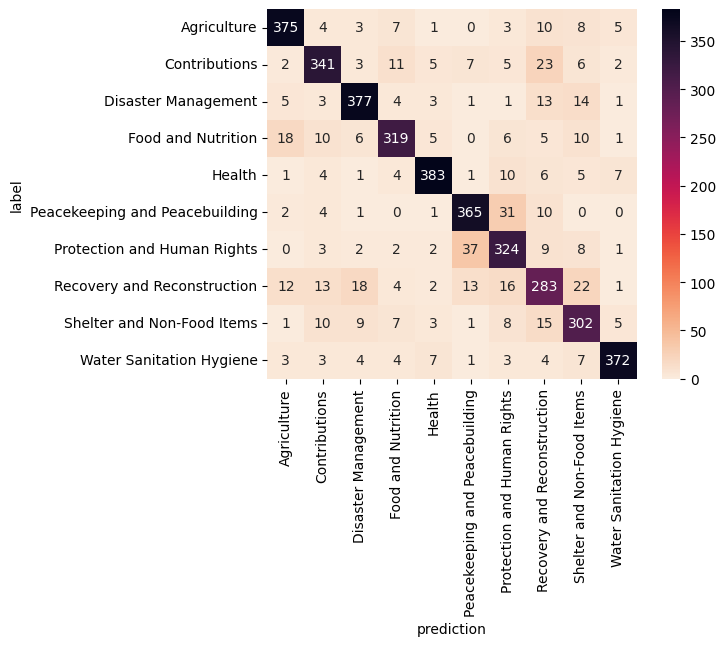

In [12]:
# Confusion matrix
conf_df = pd.DataFrame(data=confusion_matrix(test_df_labels['theme_name'], y_pred, labels=model.classes_),
                      index=model.classes_, columns=model.classes_)
ax = sns.heatmap(conf_df, cmap = sns.cm.rocket_r, annot = True, fmt = '.3g', square=True)
ax.set_ylabel('label')
ax.set_xlabel('prediction')
None

In [13]:
## Create dataframe for Tfidf weights to see which words are most associated with a document
# Used SIADS 655 HW1 Jupyter notebook as reference
xtest_array = xtest_tfidf.toarray()
df_tfidf_test = pd.DataFrame(data = xtest_array, index = test_df['report_id'], columns = tfidf.get_feature_names_out())
print(df_tfidf_test.shape)
display(df_tfidf_test.head())

(4000, 5000)


,00,000,000 000,000 children,000 displaced,000 families,000 hectares,000 households,000 mt,000 people,...,youtube,yuan,zambia,zaporizhzhya,zealand,zero,zimbabwe,znpp,zone,zones
report_id,,,,,,,,,,,,,,,,,,,,,
2961539,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450443,0.0,0.119838,0.0,0.0,0.0,0.0,0.140588,0.0,0.0,0.000000,...,0.0,0.153675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327889,0.0,0.091790,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.060217,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449428,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3226008,0.0,0.046544,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
## Extract top 10 words per document
# Reference: https://stackoverflow.com/questions/64743583/which-10-words-has-the-highest-tf-idf-value-in-each-document-total

# Get index for values sorted in ascending order by weight within each row (document)
idx = xtest_array.argsort(axis=1)
# Get top 10 weights for each document
tfidf_max10 = idx[:,-10:]
# Use vocabulary to convert weight to word, and add top 10 words for each document as column
reverse_vocab_index = {v:k for k, v in tfidf.vocabulary_.items()}
df_test_meta['top10'] = [[reverse_vocab_index[idx] for idx in row] for row in tfidf_max10 ]
display(df_test_meta.head())

,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
0,2961539,[4599],Peacekeeping and Peacebuilding,Q&A: Why new peace talks on CAR really matter,"YAOUNDÉ/Cameroon, 22 January 2019 **As a new ...",Q&A: Why new peace talks on CAR really matter ...,https://reliefweb.int/node/2961539,6.57,20.48,caf,...,1414,The New Humanitarian,News and Press Release,117.0,911,peace talk matter round peace talk arm group g...,5,Peacekeeping and Peacebuilding,0.596463,"[african, story, 01, interview, 2019, talks, c..."
1,450443,[4603],Shelter and Non-Food Items,Central gov't sends relief goods to flood-hit ...,China's civil affairs ministry on Monday distr...,Central gov't sends relief goods to flood-hit ...,https://reliefweb.int/node/450443,35.49,101.90,chn,...,1424,Xinhua,News and Press Release,187.0,1117,central sends relief good civil affair ministr...,8,Agriculture,0.585131,"[rains, 000 hectares, ministry, region, weathe..."
2,327889,[4589],Contributions,"Finland grants EUR 300,000 for earthquake assi...",Press release 258/2009 Minister for Foreign Tr...,"Finland grants EUR 300,000 for earthquake assi...",https://reliefweb.int/node/327889,-2.28,117.37,idn,...,750,Government of Finland,News and Press Release,209.0,1316,finland grant earthquake assistance release de...,1,Contributions,0.931762,"[red, 300 000, red cross, earthquake, indonesi..."
3,449428,[4604],Water Sanitation Hygiene,Korean troops help provide clean water for Hai...,Korea’s fourth peacekeeping contingent is winn...,Korean troops help provide clean water for Hai...,https://reliefweb.int/node/449428,19.18,-72.43,hti,...,1178,Korean Information Service,News and Press Release,268.0,1629,korean troop provide clean water resident four...,9,Water Sanitation Hygiene,0.905521,"[defense, unit, missions, successfully, dispat..."
4,3226008,[4587],Agriculture,How Dry Is the Thai Drought This Year?,"By Asaree Thaitrakulpanich, Staff Reporter - J...",How Dry Is the Thai Drought This Year? By Asar...,https://reliefweb.int/node/3226008,15.13,101.02,tha,...,44214,Khaosod English,News and Press Release,147.0,908,past wet season boat restaurant fill tourist p...,0,Agriculture,0.739243,"[promise, gen, wet, 2019, drought, dry, boat, ..."


In [15]:
# Subset to misclassified documents
df_misclas = df_test_meta[df_test_meta['theme_name'] != df_test_meta['predicted_theme']]
print(df_misclas.shape)
df_misclas.head()

(559, 22)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
1,450443,[4603],Shelter and Non-Food Items,Central gov't sends relief goods to flood-hit ...,China's civil affairs ministry on Monday distr...,Central gov't sends relief goods to flood-hit ...,https://reliefweb.int/node/450443,35.49,101.90,chn,...,1424,Xinhua,News and Press Release,187.0,1117,central sends relief good civil affair ministr...,8,Agriculture,0.585131,"[rains, 000 hectares, ministry, region, weathe..."
6,2351414,[4601],Recovery and Reconstruction,UN presented Social Cohesion and Reconciliatio...,"On 28 November, UNDP, UNICEF, IOM launched the...",UN presented Social Cohesion and Reconciliatio...,https://reliefweb.int/node/2351414,49.32,31.32,ukr,...,3621,UN Country Team in Ukraine,News and Press Release,326.0,2108,present launch theun sophisticated analytical ...,7,Peacekeeping and Peacebuilding,0.531333,"[use, social, analysis, reconciliation, change..."
8,3709704,[4595],Health,"By car, plane and boat: Reaching the most remo...",Story and photos by Angela Hill / IFRC For th...,"By car, plane and boat: Reaching the most remo...",https://reliefweb.int/node/3709704,5.62,-58.97,guy,...,1048,International Committee of the Red Cross,News and Press Release,544.0,2955,car plane boat remote community photo field te...,4,Water Sanitation Hygiene,0.718684,"[red, cross, car, hot, bags, covid, covid 19, ..."
19,361959,[4587],Agriculture,Zambia: Recent developments in agricultural re...,Key Trends Since 2000 - Zambia's historical tr...,Zambia: Recent developments in agricultural re...,https://reliefweb.int/node/361959,-14.00,27.43,zmb,...,1291,International Food Policy Research Institute,Analysis,174.0,1190,developments agricultural research historical ...,0,Contributions,0.553740,"[derived, national government, numbers, fundin..."
29,299548,[4589],Contributions,Assistance by the United Nations Trust Fund fo...,"On 2 March, the Government of Japan and the Un...",Assistance by the United Nations Trust Fund fo...,https://reliefweb.int/node/299548,40.61,44.66,arm,...,708,Government of Japan,News and Press Release,275.0,1774,assistance project decide extend assistance to...,1,Recovery and Reconstruction,0.676101,"[internally displaced, nations, united nations..."


In [16]:
# Most misclassified themes
test_df_wrong_counts = df_misclas['theme_name'].value_counts(ascending = False).reset_index()
display(test_df_wrong_counts)

,theme_name,count
0,Recovery and Reconstruction,101
1,Contributions,64
2,Protection and Human Rights,64
3,Food and Nutrition,61
4,Shelter and Non-Food Items,59
5,Peacekeeping and Peacebuilding,49
6,Disaster Management,45
7,Agriculture,41
8,Health,39
9,Water Sanitation Hygiene,36


### Functions for comparing misclassified documents

In [17]:
# Function that subsets for misclassified documents given actual and predicted themes
def subset_themes(orig_df, actual_theme, pred_theme):
  df_sub = orig_df[(orig_df['theme_name'] == actual_theme) & (orig_df['predicted_theme'] == pred_theme)]
  # Sort dataframe from highest to lowest probability
  df_sub = df_sub.sort_values(by = 'prob', ascending = False)
  print(df_sub.shape)
  # Print top 5 and bottom 5 rows based on probability
  display(df_sub.head())
  display(df_sub.tail())
  return df_sub

# Function that outputs text for all misclassified documents
# Used SIADS 655 HW1 Jupyter notebook as reference
def print_misclas_text(misclas_df):
  for _, row in misclas_df.iterrows():
    print(f"report_id {row['report_id']}, title: {row['title']}")
    print(f"probability {round(row['prob'], 2)} with top words {row['top10']}")
    print(row['text'][:200])
    print(row['cleaned_text'][:200] + '\n')

### Protection (actual) vs Peacekeeping (predicted)
9.5% Protection documents misclassified as Peacekeeping (37 documents total)

In [18]:
# Compare Protection (actual) vs Peacekeeping (predicted)
df_prot_peace = subset_themes(df_misclas, 'Protection and Human Rights', 'Peacekeeping and Peacebuilding')
print_misclas_text(df_prot_peace)

(37, 22)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
676,326718,[4600],Protection and Human Rights,Philippines: Razon - Gov't to pursue peaceful ...,"Written by By Ben Cal MANILA, Oct. 1 - The roa...",Philippines: Razon - Gov't to pursue peaceful ...,https://reliefweb.int/node/326718,11.74,122.88,phl,...,697,Government of the Philippines,News and Press Release,741.0,4598,philippines pursue peaceful end arm conflict r...,6,Peacekeeping and Peacebuilding,0.966780,"[insurgency, supreme, consultation, rebel, phi..."
3693,208174,[4600],Protection and Human Rights,"Sudan: Interview of Robert B. Zoellick, Deputy...","2006/511 Grosvenor House Hotel London, United...","Sudan: Interview of Robert B. Zoellick, Deputy...",https://reliefweb.int/node/208174,15.00,30.00,sdn,...,1380,US Department of State,News and Press Release,3539.0,19444,take time focus important issue agenda moment ...,6,Peacekeeping and Peacebuilding,0.964609,"[lot, khartoum, mind, movements, think, darfur..."
2483,273241,[4600],Protection and Human Rights,Seventeenth progress report of the Secretary-G...,I. Introduction 1. By its resolution 1795 (200...,Seventeenth progress report of the Secretary-G...,https://reliefweb.int/node/273241,7.81,-5.38,civ,...,1430,UN Security Council,UN Document,761.0,4976,progress report resolution extend mandate requ...,6,Peacekeeping and Peacebuilding,0.949175,"[supplementary, agreements, disarmament, 2008,..."
3838,1727126,[4600],Protection and Human Rights,South Sudan: Options in Crisis; Testimony befo...,"*Author: Dr. Jok Madut Jok* Chairman Corker, ...",South Sudan: Options in Crisis; Testimony befo...,https://reliefweb.int/node/1727126,6.90,30.50,ssd,...,14524,The Sudd Institute,News and Press Release,2362.0,13775,member member invite today steadfast support f...,6,Peacekeeping and Peacebuilding,0.936804,"[south, agreements, leaders, ordinary, sudan, ..."
2469,405094,[4600],Protection and Human Rights,Government Presents New Proposals for Solution...,"Khartoum, May 31 (SUNA)- The government has de...",Government Presents New Proposals for Solution...,https://reliefweb.int/node/405094,15.00,30.00,sdn,...,1196,Sudanese News Agency,News and Press Release,478.0,2951,government issue government declare proposal s...,6,Peacekeeping and Peacebuilding,0.934273,"[shall, existence, arab, till, joint, liberati..."


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
1705,536725,[4600],Protection and Human Rights,Training of 300 Congolese officers in Kasaï Oc...,"Kananga, 8 November 2012 - The second session ...",Training of 300 Congolese officers in Kasaï Oc...,https://reliefweb.int/node/536725,-4.03833,21.7587,cod,...,4316,UN Organization Stabilization Mission in the D...,News and Press Release,210.0,1332,training congolese officer session basic train...,6,Peacekeeping and Peacebuilding,0.414939,"[2012, 300, unit, session, provincial, trainin..."
3247,794776,[4600],Protection and Human Rights,South Darfur state emergency measures to be co...,"The emergency measures, imposed by the governm...",South Darfur state emergency measures to be co...,https://reliefweb.int/node/794776,15.00000,30.0000,sdn,...,3967,Radio Dabanga,News and Press Release,159.0,916,state emergency measure continue emergency mea...,6,Peacekeeping and Peacebuilding,0.380884,"[hussein, prison, half, emergency, state, meas..."
2473,552829,[4600],Protection and Human Rights,Statement by ICC Prosecutor concerning Mali,My Office is aware of reports that Malian forc...,Statement by ICC Prosecutor concerning Mali My...,https://reliefweb.int/node/552829,17.35000,-1.2500,mli,...,2898,International Criminal Court,News and Press Release,102.0,575,aware report malian force commit abuse recent ...,6,Peacekeeping and Peacebuilding,0.380094,"[principle, committed, prosecutor, icc, respon..."
3594,737731,[4600],Protection and Human Rights,More must be done to support the people and go...,"(Addis Ababa, 25 November 2014): At the end ...",More must be done to support the people and go...,https://reliefweb.int/node/737731,8.63000,39.6200,eth,...,1503,UN Office for the Coordination of Humanitarian...,News and Press Release,518.0,3125,support people government generously host refu...,6,Peacekeeping and Peacebuilding,0.307537,"[plight, refugee, 600 000, refugees, south sud..."
3773,515863,[4600],Protection and Human Rights,Chronic violence: toward a new approach to 21s...,This policy brief proposes the concept of “chr...,Chronic violence: toward a new approach to 21s...,https://reliefweb.int/node/515863,3.90000,-73.0700,col,...,4299,Norwegian Centre for Conflict Resolution,Analysis,241.0,1571,chronic violence approach violence policy prop...,6,Peacekeeping and Peacebuilding,0.287102,"[complex, democracy, approaches, brief, social..."


report_id 326718, title: Philippines: Razon - Gov't to pursue peaceful end to armed conflict
probability 0.97 with top words ['insurgency', 'supreme', 'consultation', 'rebel', 'philippine', 'armed', 'peace', 'rebels', 'armed conflict', 'justice']
Written by By Ben Cal MANILA, Oct. 1 - The road to peace is protracted and exacting journey, but the government is steadfast in its effort to put an end to the long-drawn armed conflict besetting the 
philippines pursue peaceful end arm conflict road peace protract exact journey government steadfast effort put end arm conflict beset country reiterate government policy achieve comprehensive agreemen

report_id 208174, title: Sudan: Interview of Robert B. Zoellick, Deputy Secretary of State, by Mina Al-Oraibi of Asharq Al Awsat
probability 0.96 with top words ['lot', 'khartoum', 'mind', 'movements', 'think', 'darfur', 'rebel', 'question', 'african union', 'accord']
2006/511  Grosvenor House Hotel London, United Kingdom May 17, 2006 10 A.M. QUEST

### Peacekeeping vs Protection
7.5% Peacekeeping documents misclassified as Protection (31 documents)

In [19]:
df_peace_prot = subset_themes(df_misclas, 'Peacekeeping and Peacebuilding', 'Protection and Human Rights')
print_misclas_text(df_peace_prot)

(31, 22)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
3509,3937585,[4599],Peacekeeping and Peacebuilding,Tunisia: Wave of Arrests Targets Critics and O...,"**President Charges a ""Conspiracy” But Provide...",Tunisia: Wave of Arrests Targets Critics and O...,https://reliefweb.int/node/3937585,34.11000,9.5600,tun,...,1966,Human Rights Watch,News and Press Release,975.0,6013,authority arrest critic bring number public fi...,5,Protection and Human Rights,0.959073,"[arrest, terrorism, february, judges, watch, o..."
142,1058636,[4599],Peacekeeping and Peacebuilding,ICC Prosecutor says determination to bring jus...,29 June 2015 – Over six years since the issuan...,ICC Prosecutor says determination to bring jus...,https://reliefweb.int/node/1058636,15.00000,30.0000,sdn,...,1546,UN News Centre,News and Press Release,685.0,4307,determination bring justice people remain unsh...,5,Protection and Human Rights,0.844542,"[justice, wanted, unamid, south africa, www or..."
3760,3943340,[4599],Peacekeeping and Peacebuilding,MEDIA ADVISORY - Press conference by the UN In...,The members of the UN Independent Internationa...,MEDIA ADVISORY - Press conference by the UN In...,https://reliefweb.int/node/3943340,49.32000,31.3200,ukr,...,2689,UN Human Rights Council,News and Press Release,244.0,1696,conference member give hybrid press conference...,5,Protection and Human Rights,0.841582,"[participation, human rights, media, independe..."
1400,501552,[4599],Peacekeeping and Peacebuilding,Fighting in Kachin State detailed in Free Burm...,"Tuesday, 05 June 2012 13:19 Mizzima News ...",Fighting in Kachin State detailed in Free Burm...,https://reliefweb.int/node/501552,21.15000,96.5100,mmr,...,2500,Mizzima News,News and Press Release,130.0,771,fighting detail report group conduct humanitar...,5,Protection and Human Rights,0.785149,"[killed, burmese, state, attacks, ethnic, free..."
587,1155761,[4599],Peacekeeping and Peacebuilding,Between Hope and Skepticism: Congolese Await t...,*The following commentary was written by Olivi...,Between Hope and Skepticism: Congolese Await t...,https://reliefweb.int/node/1155761,-4.03833,21.7587,cod,...,1278,Open Society Foundations,News and Press Release,1287.0,7921,commentary write consultation activists view o...,5,Protection and Human Rights,0.760713,"[rwanda, words, crimes, kivu, court, north kiv..."


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
3217,4009897,[4599],Peacekeeping and Peacebuilding,Explainer: What is a UN General Assembly emerg...,As the UN’s 193 Member States meet on how to a...,Explainer: What is a UN General Assembly emerg...,https://reliefweb.int/node/4009897,31.9522,35.2332,pse,...,1546,UN News Centre,News and Press Release,876.0,6000,emergency special session matter meet address ...,5,Protection and Human Rights,0.492327,"[member states, matters, resolutions, general ..."
1269,2479564,[4599],Peacekeeping and Peacebuilding,UN volunteers crucial to protecting civilians ...,"FRANCESCA MOLD In May 2015, Kweku Bassaw was w...",UN volunteers crucial to protecting civilians ...,https://reliefweb.int/node/2479564,6.9000,30.5000,ssd,...,8793,UN Mission in South Sudan,News and Press Release,547.0,3150,volunteer crucial protect civilian build peace...,5,Protection and Human Rights,0.482039,"[sought, base, site, south, tell, volunteer, p..."
1582,439132,[4599],Peacekeeping and Peacebuilding,Russia-Georgia Relations Remain Frozen Three Y...,"James Brooke | Mereti, Georgia Three years...",Russia-Georgia Relations Remain Frozen Three Y...,https://reliefweb.int/node/439132,42.1800,43.5200,geo,...,1371,Voice of America,News and Press Release,555.0,3362,relations remain frozen years shooting year wa...,5,Protection and Human Rights,0.438419,"[military, occupied, attempt, regime, won, ann..."
3601,3860649,[4599],Peacekeeping and Peacebuilding,Uganda’s Future: Navigating a Precarious Trans...,Who will succeed Ugandan President Yoweri Muse...,Uganda’s Future: Navigating a Precarious Trans...,https://reliefweb.int/node/3860649,1.2800,32.3900,uga,...,1278,Open Society Foundations,Analysis,202.0,1267,succeed circumstance advance turn year power l...,5,Protection and Human Rights,0.386812,"[international community, ugandan, particular,..."
333,419917,[4599],Peacekeeping and Peacebuilding,CARE crée des « centres d’écoute » pour favori...,Les élections de novembre 2010 ont engendré de...,CARE crée des « centres d’écoute » pour favori...,https://reliefweb.int/node/419917,7.8100,-5.3800,civ,...,1457,CARE International,News and Press Release,410.0,2347,des centre pour favoriser de novembre ont terr...,5,Protection and Human Rights,0.358815,"[ivoire, côte, côte ivoire, que, la, le, des, ..."


report_id 3937585, title: Tunisia: Wave of Arrests Targets Critics and Opposition Figures [EN/AR]
probability 0.96 with top words ['arrest', 'terrorism', 'february', 'judges', 'watch', 'opposition', 'arrests', 'charges', 'rights watch', 'arrested']
**President Charges a "Conspiracy” But Provides No Evidence**  (Tunis) – Tunisian authorities have arrested three critics of President Kais Saied since February 22, bringing the number of public figur
authority arrest critic bring number public figure deem critical bar today president denounce terrorist roundup big grant extraordinary power announce take supervision public prosecution begin initial

report_id 1058636, title: ICC Prosecutor says determination to bring justice to people of Sudan remains ‘unshaken’
probability 0.84 with top words ['justice', 'wanted', 'unamid', 'south africa', 'www org', 'darfur', 'court', 'arrest', 'prosecutor', 'icc']
29 June 2015 – Over six years since the issuance of the first warrant of arrest against Suda

### Food vs Agriculture
4.7% Food documents misclassified as Agriculture (18 documents)

In [21]:
df_food_ag = subset_themes(df_misclas, 'Food and Nutrition', 'Agriculture')
print_misclas_text(df_food_ag)

(18, 22)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
1031,216565,[4593],Food and Nutrition,Sierra Leone: The World Food Day Celebratation...,Mr. Chairman President of the National Associa...,Sierra Leone: The World Food Day Celebratation...,https://reliefweb.int/node/216565,8.56,-11.79,sle,...,641,Government of Sierra Leone,News and Press Release,3151.0,19515,member year ago pledge people country work ear...,3,Agriculture,0.979326,"[food security, production, export, productivi..."
2397,371096,[4593],Food and Nutrition,Nigeria: Profiles of Progress - Cowpea Storage...,"Balarabe Kausani, a smallholder farmer in nort...",Nigeria: Profiles of Progress - Cowpea Storage...,https://reliefweb.int/node/371096,9.59,8.11,nga,...,710,Bill & Melinda Gates Foundation,News and Press Release,720.0,4188,smallholder farmer northern earn money make im...,3,Agriculture,0.939354,"[50 percent, sell, farmer, harvest, nigeria, s..."
2622,421547,[4593],Food and Nutrition,End of Mission to Mexico: Mexico requires a ne...,I. Introduction The Special Rapporteur on the...,End of Mission to Mexico: Mexico requires a ne...,https://reliefweb.int/node/421547,23.95,-102.53,mex,...,2689,UN Human Rights Council,News and Press Release,4954.0,32416,end require strategy overcome twin challenge f...,3,Agriculture,0.938916,"[special, agricultural, arid, programmes, righ..."
638,3881358,[4593],Food and Nutrition,ADB Approves $200 Million Loan to Mitigate Sri...,"MANILA, PHILIPPINES (30 August 2022) — The Asi...",ADB Approves $200 Million Loan to Mitigate Sri...,https://reliefweb.int/node/3881358,7.61,80.70,lka,...,326,Asian Development Bank,News and Press Release,553.0,3775,approves approve emergency assistance loan fun...,3,Agriculture,0.919509,"[node, reliefweb, reliefweb int, disabilities,..."
3396,381566,[4593],Food and Nutrition,KENYA: FOOD SECURITY ASSESSMENT TEAM TOUR OF M...,A food security assessment team led by an assi...,KENYA: FOOD SECURITY ASSESSMENT TEAM TOUR OF M...,https://reliefweb.int/node/381566,0.53,37.86,ken,...,475,Government of Kenya,News and Press Release,590.0,3622,food security assessment team lead assistant m...,3,Agriculture,0.909925,"[cereals, farmers, crop, drought, assistant, s..."


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,...,source_id,source_name,format,word_count,len_text,cleaned_text,category_id,predicted_theme,prob,top10
3034,3733008,[4593],Food and Nutrition,Saint Vincent and the Grenadines Agriculture M...,**Media Release Courtesy the Inter-American In...,Saint Vincent and the Grenadines Agriculture M...,https://reliefweb.int/node/3733008,13.25,-61.19,vct,...,2176,Organisation of Eastern Caribbean States,News and Press Release,216.0,1288,catastrophic situation suffer series volcanic ...,3,Agriculture,0.623191,"[volcano, eruption, cooperation, nation, agric..."
3216,323518,[4593],Food and Nutrition,RP to donate corn to Kenya,President Gloria Macapagal-Arroyo today direct...,RP to donate corn to Kenya President Gloria Ma...,https://reliefweb.int/node/323518,0.53,37.86,ken,...,697,Government of the Philippines,News and Press Release,212.0,1271,donate corn today direct work donation corn su...,3,Agriculture,0.612231,"[drought, immigration, market, philippines, do..."
3043,366037,[4593],Food and Nutrition,Elderly among the most vulnerable in flood-hit...,"""We have just enough food to last for a few mo...",Elderly among the most vulnerable in flood-hit...,https://reliefweb.int/node/366037,29.97,69.39,pak,...,1052,Trócaire,News and Press Release,359.0,1870,elderly vulnerable food week cope flood surviv...,3,Agriculture,0.575227,"[lost, trying, seeds, think, crops, pakistan, ..."
2101,360556,[4593],Food and Nutrition,"Niger/Mali: 290,000 people benefit from massiv...",Niamey (ICRC) - Farmers and stockbreeders in n...,"Niger/Mali: 290,000 people benefit from massiv...",https://reliefweb.int/node/360556,17.43,9.40,ner,...,1048,International Committee of the Red Cross,News and Press Release,387.0,2345,people benefit massive aid operation stockbree...,3,Agriculture,0.543248,"[farmers, northern, 000 people, livestock, see..."
976,3652550,[4593],Food and Nutrition,COVID-19 Food Security Response Situation Repo...,"Reporting Period: June 15-July 11, 2020 Rel...",COVID-19 Food Security Response Situation Repo...,https://reliefweb.int/node/3652550,6.45,-9.31,lbr,...,2619,Government of Liberia,Situation Report,314.0,1870,rise case issue extend additional month previo...,3,Agriculture,0.464352,"[rising, july, june, 19, 2020, 00, reporting p..."


report_id 216565, title: Sierra Leone: The World Food Day Celebratations at the Community Centre Grounds in Doidu Town, Kono District on 16th October 2006 - Speech of the President
probability 0.98 with top words ['food security', 'production', 'export', 'productivity', 'leone', 'sierra leone', 'chairman', 'rice', 'sierra', 'cassava']
Mr. Chairman President of the National Association of Farmers of Sierra Leone Cabinet Ministers Members of Parliament Traditional Rulers Your Excellencies, members of the Diplomatic Corps Members of C
member year ago pledge people country work earnestly provide enable environment require make sufficient food production increase agricultural productivity celebration today opportunity ass road achiev

report_id 371096, title: Nigeria: Profiles of Progress - Cowpea Storage Project
probability 0.94 with top words ['50 percent', 'sell', 'farmer', 'harvest', 'nigeria', 'storage', 'farmers', 'central africa', 'researchers', 'bags']
Balarabe Kausani, a smallholde